<a href="https://colab.research.google.com/github/Mariammmmmmm/CourseWork/blob/main/Spark_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 57.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=51c2b92ab5065f60b637acea4f7a6ccb9213eaa10d641c3d734bc74a54334eae
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('Dataframe').getOrCreate()
spark

In [ ]:
df_pyspark=spark.read.csv('IndianFinancialNews.csv',header=True,inferSchema=True)
df_pyspark = df_pyspark.dropna()
df_pyspark.show(10)

+---+--------------------+--------------------+--------------------+
|_c0|                Date|               Title|         Description|
+---+--------------------+--------------------+--------------------+
|  0|May 26, 2020, Tue...|ATMs to become vi...|Close to 14.6 per...|
|  1|May 26, 2020, Tue...|IDFC First Bank s...|V Vaidyanathan, m...|
|  2|May 25, 2020, Monday|Huge scam in YES ...|Rana Kapoor's wif...|
|  3|May 24, 2020, Sunday|Bank of Maharasht...|The bank said it ...|
|  4|May 23, 2020, Sat...|DCB Bank's profit...|Net profit for th...|
|  5|May 23, 2020, Sat...|Bank of Baroda to...|Under the scheme,...|
|  6|May 22, 2020, Friday|Retail, MSME loan...|HDFC Bank cuts ba...|
|  7|May 22, 2020, Friday|RBI forecasts eco...|"The six-member M...|
|  8|May 22, 2020, Friday|RBI extends loan ...|The central bank ...|
|  9|May 22, 2020, Friday|Govt seeks to rai...|Two new series wi...|
+---+--------------------+--------------------+--------------------+
only showing top 10 rows



In [ ]:
df_pyspark.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Description: string (nullable = true)



In [ ]:
import nltk
from nltk.corpus import wordnet 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# convert to lower case, removing stop words, numbers / non-alphabetic characters, lemmatization.

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

def clear(text):
  text = text.lower()
  text = list(filter(str.isalpha, word_tokenize(text.lower())))
  text = list(lemmatizer.lemmatize(word) for word in text)
  text = list(word for word in text if word not in stop_words)
  new_text = ' '.join(text)
  return new_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
clear_udf = F.udf(f=lambda row: clear(row), returnType=T.StringType())
df_pyspark = df_pyspark.withColumn("Description", clear_udf(F.col("Description")))
df_pyspark.show(10)

+---+--------------------+--------------------+--------------------+
|_c0|                Date|               Title|         Description|
+---+--------------------+--------------------+--------------------+
|  0|May 26, 2020, Tue...|ATMs to become vi...|close per cent at...|
|  1|May 26, 2020, Tue...|IDFC First Bank s...|v vaidyanathan ma...|
|  2|May 25, 2020, Monday|Huge scam in YES ...|rana kapoor wife ...|
|  3|May 24, 2020, Sunday|Bank of Maharasht...|bank gearing exte...|
|  4|May 23, 2020, Sat...|DCB Bank's profit...|net profit financ...|
|  5|May 23, 2020, Sat...|Bank of Baroda to...|scheme government...|
|  6|May 22, 2020, Friday|Retail, MSME loan...|hdfc bank cut bas...|
|  7|May 22, 2020, Friday|RBI forecasts eco...|mpc also kept pol...|
|  8|May 22, 2020, Friday|RBI extends loan ...|central bank incr...|
|  9|May 22, 2020, Friday|Govt seeks to rai...|two new series ma...|
+---+--------------------+--------------------+--------------------+
only showing top 10 rows



In [ ]:
def remove_punkt(text):
    text = re.sub(r"[0-9_-]", "", text)
    text = re.sub(r"\s+"," ",  text)
    text = text.strip()
    return text

remove_punkt_udf = F.udf(f=lambda row: remove_punkt(row), returnType=T.StringType())
df_pyspark = df_pyspark.withColumn("Description", remove_punkt_udf(F.col("Description")))
df_pyspark.show(10)

+---+--------------------+--------------------+--------------------+
|_c0|                Date|               Title|         Description|
+---+--------------------+--------------------+--------------------+
|  0|May 26, 2020, Tue...|ATMs to become vi...|close per cent at...|
|  1|May 26, 2020, Tue...|IDFC First Bank s...|v vaidyanathan ma...|
|  2|May 25, 2020, Monday|Huge scam in YES ...|rana kapoor wife ...|
|  3|May 24, 2020, Sunday|Bank of Maharasht...|bank gearing exte...|
|  4|May 23, 2020, Sat...|DCB Bank's profit...|net profit financ...|
|  5|May 23, 2020, Sat...|Bank of Baroda to...|scheme government...|
|  6|May 22, 2020, Friday|Retail, MSME loan...|hdfc bank cut bas...|
|  7|May 22, 2020, Friday|RBI forecasts eco...|mpc also kept pol...|
|  8|May 22, 2020, Friday|RBI extends loan ...|central bank incr...|
|  9|May 22, 2020, Friday|Govt seeks to rai...|two new series ma...|
+---+--------------------+--------------------+--------------------+
only showing top 10 rows



In [ ]:
def split_description(data):
  data_words = data.split(' ')
  return data_words

split_description_udf = F.udf(f=lambda row: split_description(row), returnType=T.ArrayType(T.StringType()))
df_pyspark = df_pyspark.withColumn("Description_split", split_description_udf(F.col("Description")))
df_pyspark.show(10)

+---+--------------------+--------------------+--------------------+--------------------+
|_c0|                Date|               Title|         Description|   Description_split|
+---+--------------------+--------------------+--------------------+--------------------+
|  0|May 26, 2020, Tue...|ATMs to become vi...|close per cent at...|[close, per, cent...|
|  1|May 26, 2020, Tue...|IDFC First Bank s...|v vaidyanathan ma...|[v, vaidyanathan,...|
|  2|May 25, 2020, Monday|Huge scam in YES ...|rana kapoor wife ...|[rana, kapoor, wi...|
|  3|May 24, 2020, Sunday|Bank of Maharasht...|bank gearing exte...|[bank, gearing, e...|
|  4|May 23, 2020, Sat...|DCB Bank's profit...|net profit financ...|[net, profit, fin...|
|  5|May 23, 2020, Sat...|Bank of Baroda to...|scheme government...|[scheme, governme...|
|  6|May 22, 2020, Friday|Retail, MSME loan...|hdfc bank cut bas...|[hdfc, bank, cut,...|
|  7|May 22, 2020, Friday|RBI forecasts eco...|mpc also kept pol...|[mpc, also, kept,...|
|  8|May 2

In [ ]:
df_help = df_pyspark.cache()
from pyspark.ml import feature
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="Description_split", outputCol="rawFeatures", vocabSize=10000, minDF=5)
cvmodel = cv.fit(df_help)
featurizedData = cvmodel.transform(df_help)
featurizedData.show(10)

+---+--------------------+--------------------+--------------------+--------------------+--------------------+
|_c0|                Date|               Title|         Description|   Description_split|         rawFeatures|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|May 26, 2020, Tue...|ATMs to become vi...|close per cent at...|[close, per, cent...|(6110,[1,8,11,155...|
|  1|May 26, 2020, Tue...|IDFC First Bank s...|v vaidyanathan ma...|[v, vaidyanathan,...|(6110,[8,11,79,11...|
|  2|May 25, 2020, Monday|Huge scam in YES ...|rana kapoor wife ...|[rana, kapoor, wi...|(6110,[76,1531,16...|
|  3|May 24, 2020, Sunday|Bank of Maharasht...|bank gearing exte...|[bank, gearing, e...|(6110,[0,15,81,13...|
|  4|May 23, 2020, Sat...|DCB Bank's profit...|net profit financ...|[net, profit, fin...|(6110,[2,4,14,16,...|
|  5|May 23, 2020, Sat...|Bank of Baroda to...|scheme government...|[scheme, governme...|(6110,[8,11,13,19...|
|

In [ ]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate();
vocab = cvmodel.vocabulary
vocab_broadcast = sc.broadcast(vocab)
vocab

['bank',
 'india',
 'r',
 'reserve',
 'crore',
 'rbi',
 'today',
 'insurance',
 'per',
 'rate',
 'sector',
 'cent',
 'company',
 'loan',
 'year',
 'finance',
 'financial',
 'lender',
 'state',
 'government',
 'market',
 'public',
 'indian',
 'net',
 'credit',
 'private',
 'life',
 'fund',
 'capital',
 'banking',
 'profit',
 'interest',
 'new',
 'plan',
 'growth',
 'country',
 'quarter',
 'sbi',
 'foreign',
 'may',
 'bond',
 'deposit',
 'rupee',
 'development',
 'billion',
 'largest',
 'would',
 'business',
 'asset',
 'ended',
 'icici',
 'service',
 'first',
 'corporation',
 'set',
 'central',
 'investment',
 'policy',
 'raise',
 'month',
 'group',
 'increase',
 'branch',
 'dollar',
 'lending',
 'issue',
 'national',
 'week',
 'share',
 'last',
 'global',
 'likely',
 'two',
 'reported',
 'rise',
 'u',
 'also',
 'million',
 'equity',
 'cut',
 'exchange',
 'announced',
 'one',
 'account',
 'march',
 'union',
 'next',
 'time',
 'debt',
 'current',
 'governor',
 'insurer',
 'board',
 'liqui

In [ ]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
rescaledData.show(10)

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|_c0|                Date|               Title|         Description|   Description_split|         rawFeatures|            features|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|May 26, 2020, Tue...|ATMs to become vi...|close per cent at...|[close, per, cent...|(6110,[1,8,11,155...|(6110,[1,8,11,155...|
|  1|May 26, 2020, Tue...|IDFC First Bank s...|v vaidyanathan ma...|[v, vaidyanathan,...|(6110,[8,11,79,11...|(6110,[8,11,79,11...|
|  2|May 25, 2020, Monday|Huge scam in YES ...|rana kapoor wife ...|[rana, kapoor, wi...|(6110,[76,1531,16...|(6110,[76,1531,16...|
|  3|May 24, 2020, Sunday|Bank of Maharasht...|bank gearing exte...|[bank, gearing, e...|(6110,[0,15,81,13...|(6110,[0,15,81,13...|
|  4|May 23, 2020, Sat...|DCB Bank's profit...|net profit financ...|[net, pr

In [ ]:
corpus = rescaledData.select("features").cache()
corpus.show(5)

+--------------------+
|            features|
+--------------------+
|(6110,[1,8,11,155...|
|(6110,[8,11,79,11...|
|(6110,[76,1531,16...|
|(6110,[0,15,81,13...|
|(6110,[2,4,14,16,...|
+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.clustering import LDA

In [ ]:
for num_topics in range(11, 20, 2):
  print(num_topics)


11
13
15
17
19


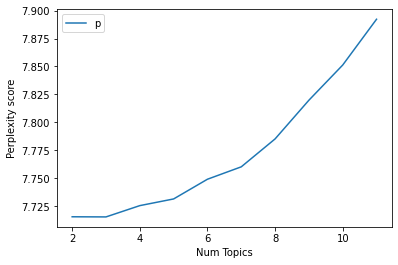

In [ ]:
import matplotlib.pyplot as plt
# Show graph
limit=20; start=11; step=2;
x = range(start, limit, step)
plt.plot(x, lp)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

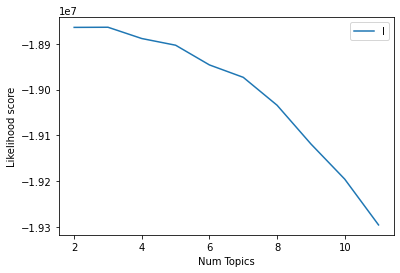

In [ ]:
import matplotlib.pyplot as plt
# Show graph
limit=20; start=11; step=2;
x = range(start, limit, step)
plt.plot(x, ll)
plt.xlabel("Num Topics")
plt.ylabel("Likelihood score")
plt.legend(("likelihood_values"), loc='best')
plt.show()

In [ ]:
print(str(ll))
print(str(lp))

-18749276.637882877
7.668558926370802


In [ ]:
lda = LDA(k=13, maxIter=50, optimizer="em")
model = lda.fit(corpus)

In [ ]:
topicwords = 20
topics = model.describeTopics(topicwords)
topics.show(truncate=False)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-----+--------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                                                                       |termWeights                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
tRDD = topics.rdd.map(list)
tRDD.collect()

[[0,
  [38,
   42,
   22,
   63,
   67,
   80,
   96,
   95,
   6,
   156,
   129,
   166,
   75,
   182,
   200,
   208,
   213,
   237,
   236,
   240],
  [0.028617957451017733,
   0.026895866785284602,
   0.0232088534289271,
   0.021430573796672625,
   0.019757719918569516,
   0.017796740652679794,
   0.01650151187802637,
   0.016400168494202862,
   0.015154964736213887,
   0.012818847918145323,
   0.012688301635528506,
   0.012126896637124396,
   0.011984602787167401,
   0.011643679775887174,
   0.010978889771813398,
   0.010395400462379934,
   0.010144282002327445,
   0.009540262802944906,
   0.009536858750628093,
   0.0092052046069351]],
 [1,
  [3,
   94,
   88,
   93,
   108,
   5,
   135,
   147,
   157,
   144,
   48,
   1,
   179,
   190,
   90,
   217,
   24,
   130,
   274,
   162],
  [0.020161560699256995,
   0.018722023537945807,
   0.018293549517024364,
   0.01811342498764025,
   0.016318279654697326,
   0.016189037659063828,
   0.014737100904094896,
   0.014119315558497

In [ ]:
def topic_vocab(topic):
  print(topic)
  topicNum = topic[0]
  terms = topic[1]
  weight = topic[2]
  result = []
  for i in range(topicwords):
    term = vocab[terms[i]]
    out = str(topicNum)+","+term+","+str(weight[i])
    out = ""+term
    result.append(out)
  
  return result

In [ ]:
def topic_vocab_only_term(topic):
  print(topic)
  topicNum = topic[0]
  terms = topic[1]
  weight = topic[2]
  result = []
  for i in range(topicwords):
    term = vocab[terms[i]]
    out = ""+term
    result.append(out)
  
  return result

In [ ]:
tRDD.map(lambda topic: topic_vocab_only_term(topic)).collect().tolist()

In [ ]:
import pandas as pd
import numpy as np
pandas_df = pd.DataFrame(tRDD, columns = ['0','1', '2', '3','4','5','6','7','8','9','10','11','12'])
pandas_df

In [ ]:
tRDD.map(lambda topic: topic_vocab(topic)).collect()

[['0,foreign,0.028617957451017733',
  '0,rupee,0.026895866785284602',
  '0,indian,0.0232088534289271',
  '0,dollar,0.021430573796672625',
  '0,week,0.019757719918569516',
  '0,exchange,0.017796740652679794',
  '0,currency,0.01650151187802637',
  '0,high,0.016400168494202862',
  '0,today,0.015154964736213887',
  '0,stock,0.012818847918145323',
  '0,day,0.012688301635528506',
  '0,trade,0.012126896637124396',
  '0,u,0.011984602787167401',
  '0,demand,0.011643679775887174',
  '0,yield,0.010978889771813398',
  '0,low,0.010395400462379934',
  '0,close,0.010144282002327445',
  '0,early,0.009540262802944906',
  '0,paisa,0.009536858750628093',
  '0,level,0.0092052046069351'],
 ['1,reserve,0.020161560699256995',
  '1,rating,0.018722023537945807',
  '1,debt,0.018293549517024364',
  '1,liquidity,0.01811342498764025',
  '1,expected,0.016318279654697326',
  '1,rbi,0.016189037659063828',
  '1,corporate,0.014737100904094896',
  '1,report,0.014119315558497336',
  '1,system,0.01354598677628888',
  '1,c

In [ ]:
topic = tRDD.map(lambda topic: topic_vacab(topic))

In [ ]:
from pyspark.mllib.linalg import SparseVector, DenseVector
import math 
import operator
from collections import Counter

def get_topic_number(vector):
  list_ex = list(vector)
  list_ex = [math.trunc(i) for i in list_ex]
  list_ex = [i for i in list_ex if i != 0]
  list_ex = dict(Counter(list_ex))
  list_ex = sorted(list_ex.items(), key=operator.itemgetter(1), reverse=True)
  return list_ex[0][0]


get_topic_number_udf = F.udf(f=lambda row: get_topic_number(row), returnType=T.IntegerType())
df = rescaledData.withColumn("topic", get_topic_number_udf(F.col("features")))
df.show(10)

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|_c0|                Date|               Title|         Description|   Description_split|         rawFeatures|            features|topic|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|  0|May 26, 2020, Tue...|ATMs to become vi...|close per cent at...|[close, per, cent...|(6110,[1,8,11,155...|(6110,[1,8,11,155...|    4|
|  1|May 26, 2020, Tue...|IDFC First Bank s...|v vaidyanathan ma...|[v, vaidyanathan,...|(6110,[8,11,79,11...|(6110,[8,11,79,11...|    4|
|  2|May 25, 2020, Monday|Huge scam in YES ...|rana kapoor wife ...|[rana, kapoor, wi...|(6110,[76,1531,16...|(6110,[76,1531,16...|    7|
|  3|May 24, 2020, Sunday|Bank of Maharasht...|bank gearing exte...|[bank, gearing, e...|(6110,[0,15,81,13...|(6110,[0,15,81,13...|    6|
|  4|May 23, 2020, Sat...|DCB Bank

In [ ]:
df1 = df.select("_c0", "topic")
df1.show(5)

+---+-----+
|_c0|topic|
+---+-----+
|  0|    4|
|  1|    4|
|  2|    7|
|  3|    6|
|  4|    3|
+---+-----+
only showing top 5 rows



In [ ]:
df = corpus.withColumn("topic", get_topic_number_udf(F.col("features")))
df.show(10)

+--------------------+-----+
|            features|topic|
+--------------------+-----+
|(6110,[1,8,11,155...|    4|
|(6110,[8,11,79,11...|    4|
|(6110,[76,1531,16...|    7|
|(6110,[0,15,81,13...|    6|
|(6110,[2,4,14,16,...|    3|
|(6110,[8,11,13,19...|    2|
|(6110,[0,9,37,79,...|    4|
|(6110,[34,57,76,6...|    3|
|(6110,[0,17,55,60...|    3|
|(6110,[32,72,273,...|    3|
+--------------------+-----+
only showing top 10 rows

